In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import time
from datetime import datetime
import single_node_profiles as snp
import profiler
import end_to_end_profiles as e2e_profs
import numpy as np
from optimizer import BruteForceOptimizer, GreedyOptimizer
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
profs = snp.load_single_node_profiles()

In [4]:
profs.keys()

dict_keys(['alexnet', 'res152', 'res18', 'res50', 'inception', 'tf-kernel-svm', 'tf-lang-detect', 'tf-log-reg', 'tf-lstm', 'tf-nmt', 'tf-resnet-feats'])

In [5]:
dag = profiler.get_logical_pipeline("pipeline_three")
with open(os.path.abspath("../results/e2e_profs/systemx/resnet_cascade/slo_500ms/alex_1-r50_1-r152_2-171025_083730.json")) as f:
    sample_run = json.load(f)
scale_factors = profiler.get_node_scale_factors(sample_run, dag.reference_node)
node_configs = profiler.get_node_configs_from_experiment(sample_run)
node_profs = {name : profiler.NodeProfile(name, profs[name]) for name, _ in node_configs.items()}

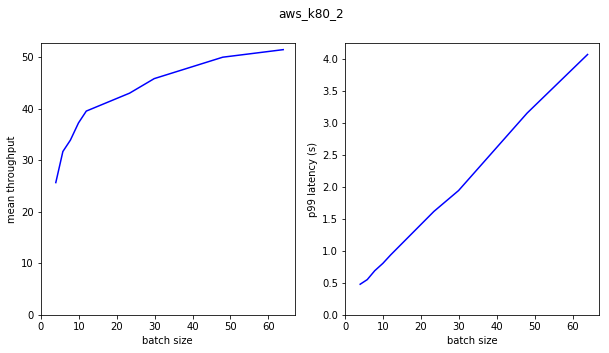

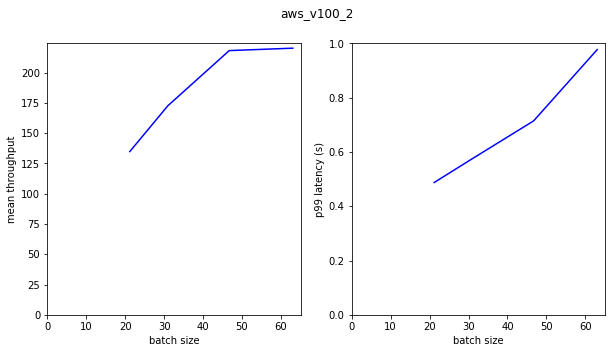

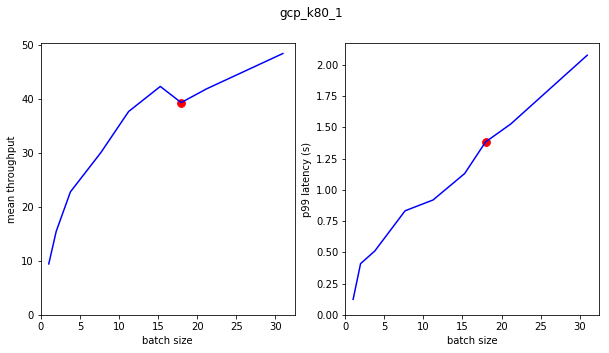

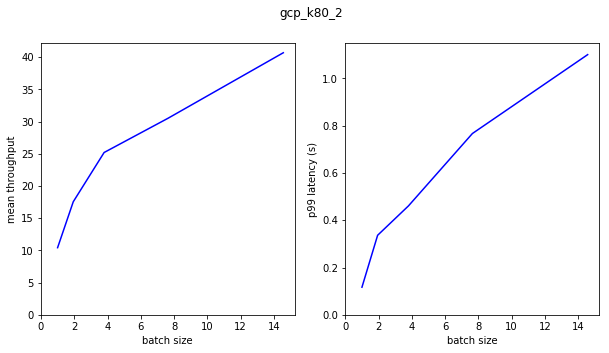

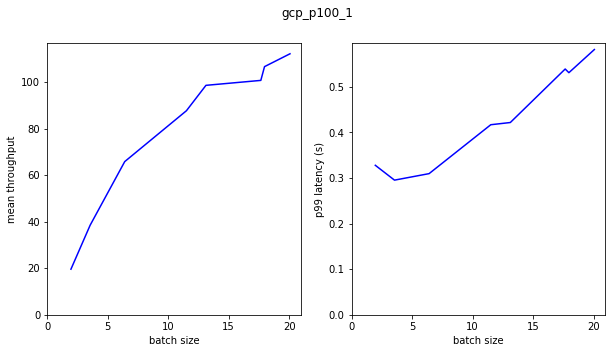

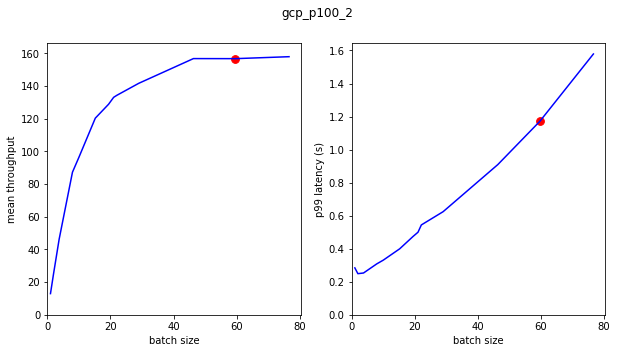

In [9]:
inception = profiler.NodeProfile("tf-resnet-feats", profs["tf-resnet-feats"])
inception.plot_profile()

In [ ]:
node_profs["res152"].plot_profile()

In [ ]:
for n, p in node_profs.items():
    p.check_monotonicity()
    r = p.plot_profile()
    break

In [ ]:
b = [True, True, False]
for i, p in enumerate(b):
    print(i,p)

In [ ]:
p = node_profs["alexnet"]
p.profile.iloc[7]["mean_batch_size"]

In [ ]:
for bundle, _ in r:
    print("-".join([str(b) for b in bundle]))

In [6]:
opt = GreedyOptimizer(dag, scale_factors, node_profs)
cloud = "gcp"
initial_config = {"alexnet": profiler.NodeConfig(name="alexnet",
                                                      num_cpus=1,
                                                      gpu_type="k80",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "res50": profiler.NodeConfig(name="res50",
                                                      num_cpus=1,
                                                      gpu_type="k80",
                                                          batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "res152": profiler.NodeConfig(name="res152",
                                                      num_cpus=1,
                                                      gpu_type="k80",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                 }
opt.select_optimal_config(cloud, 0.7, 50, initial_config)

Upgrading bottleneck node res152 to NodeConfig(res152, 1, p100, 1, 1, gcp)
Upgrading bottleneck node res50 to NodeConfig(res50, 1, p100, 1, 1, gcp)
Upgrading bottleneck node alexnet to NodeConfig(alexnet, 1, p100, 1, 1, gcp)
Upgrading bottleneck node res152 to NodeConfig(res152, 1, p100, 3.6219761022668036, 1, gcp)
Upgrading bottleneck node res50 to NodeConfig(res50, 1, p100, 1, 2, gcp)
Upgrading bottleneck node res152 to NodeConfig(res152, 1, p100, 7.942919389978213, 1, gcp)
Upgrading bottleneck node alexnet to NodeConfig(alexnet, 1, p100, 1, 2, gcp)
Upgrading bottleneck node res152 to NodeConfig(res152, 1, p100, 7.942919389978213, 2, gcp)
Upgrading bottleneck node res50 to NodeConfig(res50, 1, p100, 1, 3, gcp)
Upgrading bottleneck node alexnet to NodeConfig(alexnet, 1, p100, 1, 3, gcp)
Upgrading bottleneck node res152 to NodeConfig(res152, 1, p100, 7.942919389978213, 3, gcp)
Upgrading bottleneck node res50 to NodeConfig(res50, 1, p100, 1, 4, gcp)
Upgrading bottleneck node alexnet to 

({'alexnet': NodeConfig(alexnet, 1, p100, 7.9778411364545825, 8, gcp),
  'res152': NodeConfig(res152, 1, p100, 10.72030162514243, 7, gcp),
  'res50': NodeConfig(res50, 1, p100, 11.174747827156555, 8, gcp)},
 {'cost': 49.866999999999997,
  'latency': 0.6654874499999999,
  'throughput': 1829.821644485029})

In [ ]:
import itertools
def brute_force_optimizer(dag, scale_factors, node_profs, cost_constraint, latency_constraint):
    """
        This doesn't loo
    """
    all_node_configs = [node_profs[node].enumerate_configs(max_replication_factor=3) for node in dag.nodes()]     
    all_pipeline_configs = itertools.product(*all_node_configs)
    num_valid_configs = 0
    best_config = None
    best_config_perf = None
    cur_index = 0
    for p_config in all_pipeline_configs:
        cur_index += 1
        if cur_index % 500 == 0:
            print("Processed {}".format(cur_index))
        cur_node_configs = {n.name: n for n in p_config}
        if not profiler.is_valid_pipeline_config(cur_node_configs):
            continue
        cur_config_perf = profiler.estimate_pipeline_performance_for_config(
            dag, scale_factors, cur_node_configs, node_profs)
        if cur_config_perf["latency"] <= latency_constraint and cur_config_perf["cost"] <= cost_constraint:
            if best_config is None:
                best_config = cur_node_configs
                best_config_perf = cur_config_perf
                print("Initializing config to {} ({})".format(best_config, best_config_perf))
            else:
                if cur_config_perf["throughput"] > best_config_perf["throughput"]:
                    best_config = cur_node_configs
                    best_config_perf = cur_config_perf
                    print("Updating config to {} ({})".format(best_config, best_config_perf))
        
    return best_config, best_config_perf

In [ ]:
start = datetime.now()
brute_force_optimizer(dag, scale_factors, node_profs, 7.0, 0.8)
end = datetime.now()
print("{}".format((end-start).total_seconds()))

In [ ]:
profiler.estimate_pipeline_performance_for_config(dag, scale_factors, node_configs, node_profs)

In [ ]:
groups = profs["alexnet"].groupby(["cloud","gpu_type","num_cpus_per_replica"])
groups

In [ ]:
for name, df in groups:
    print(name, df)